# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

In [1]:
import gym, os, sys, random, copy
sys.path.append("agents")
from ddpg_agent import DDPG, Actor, Critic, OUNoise, ReplayBuffer
from task import Task, Takeoff
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from collections import namedtuple, deque, defaultdict
from keras.initializers import RandomUniform
from keras import layers, models, optimizers
from keras import backend as K
%matplotlib inline

Using TensorFlow backend.


## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [2]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [3]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

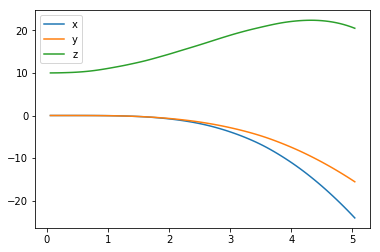

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

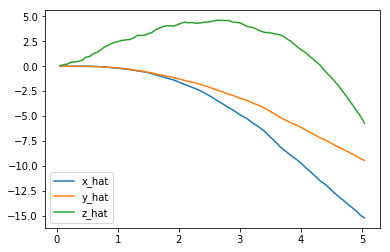

In [5]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Next, you can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

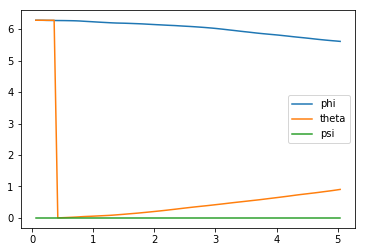

In [6]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

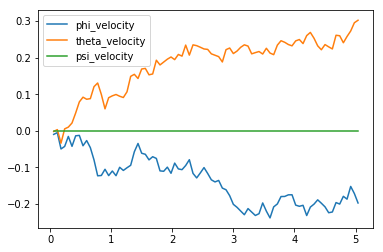

In [7]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, you can use the code cell below to print the agent's choice of actions.  

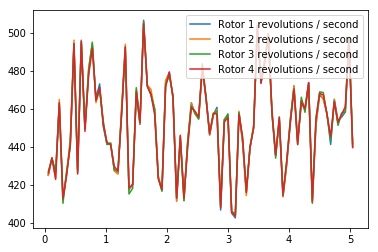

In [8]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [9]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[-24.05707351 -15.56374397  20.49230058   5.61119992   0.90586421
   0.        ]
[-15.21917058  -9.45420566  -5.71115071]
[-0.19708651  0.30185833  0.        ]


In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

In [10]:
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 1000
target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

Episode = 1000, score =  -0.152 (best =  -0.027), noise_scale = 3.25

This agent should perform very poorly on this task.  And that's where you come in!

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [11]:
# Set the task as takeoff with the goal of reaching at least a height of z = 130.

# Note: If the agent fails to learn the task quickly because it gets stuck in a local minimum or otherwise, 
# the agent will reset itself and training will resume using re-initialized actor and critic networks.
# This is checked with the 'threshold' arg taken by the train_agent method. Here, I set the threshold to 1000,
# which means that if the mean score of the last 10 episodes is not at least 1000, training will restart.
# Here I demonstrate what happens for a failed run (first ten episodes followed by a notification, and then a reset).

target_pos = np.array([0., 0., 130.])
task = Takeoff(target_pos=target_pos)
agent = DDPG(env=task, 
             env_type='copter', 
             random_seed=None, 
             max_eps=150, 
             max_steps=False, 
             train_every='step', 
             decay_noise='exp')

scores = agent.train_agent(threshold=1000)

/Users/nate/Documents/Python/MachineLearningND/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


Episode 1/150, Score = -6.0, Noise = 0.990, Time = 5.02, Final State: (-16.52, 0.54, 28.35)
Episode 2/150, Score = 57.6, Noise = 0.980, Time = 5.02, Final State: (5.62, 4.96, 31.20)
Episode 3/150, Score = 18.1, Noise = 0.970, Time = 5.02, Final State: (-6.80, 10.49, 29.96)
Episode 4/150, Score = 1.7, Noise = 0.961, Time = 5.02, Final State: (9.98, 9.19, 29.85)
Episode 5/150, Score = 12.4, Noise = 0.951, Time = 5.02, Final State: (-13.11, -3.05, 29.58)
Episode 6/150, Score = 100.5, Noise = 0.941, Time = 5.02, Final State: (-2.06, 2.73, 31.79)
Episode 7/150, Score = 1.4, Noise = 0.932, Time = 5.02, Final State: (11.58, 7.13, 29.74)
Episode 8/150, Score = -27.8, Noise = 0.923, Time = 5.02, Final State: (14.21, 8.05, 28.67)
Episode 9/150, Score = 106.1, Noise = 0.914, Time = 5.02, Final State: (1.32, -0.14, 31.93)
Episode 10/150, Score = 64.2, Noise = 0.904, Time = 5.02, Final State: (5.30, 4.15, 31.44)
Agent failed to learn or got stuck in local minimum: Resetting networks and trying agai

Episode 77/150, Score = 1267.5, Noise = 0.461, Time = 4.76, Final State: (5.95, -0.95, 130.01)
Episode 78/150, Score = 1400.3, Noise = 0.457, Time = 4.76, Final State: (-1.04, 0.30, 130.28)
Episode 79/150, Score = 1255.2, Noise = 0.452, Time = 4.78, Final State: (-6.78, 5.93, 130.39)
Episode 80/150, Score = 1269.8, Noise = 0.448, Time = 4.78, Final State: (-6.83, -1.94, 130.46)
Episode 81/150, Score = 1383.7, Noise = 0.443, Time = 4.76, Final State: (-2.28, -2.94, 130.08)
Episode 82/150, Score = 1400.1, Noise = 0.439, Time = 4.76, Final State: (-1.20, 1.90, 130.19)
Episode 83/150, Score = 1278.7, Noise = 0.434, Time = 4.76, Final State: (-1.91, 5.58, 130.04)
Episode 84/150, Score = 1258.2, Noise = 0.430, Time = 4.78, Final State: (9.09, 1.17, 130.42)
Episode 85/150, Score = 1274.3, Noise = 0.426, Time = 4.76, Final State: (2.22, 5.10, 130.21)
Episode 86/150, Score = 1245.8, Noise = 0.421, Time = 4.78, Final State: (-3.99, -8.97, 130.27)
Episode 87/150, Score = 1251.0, Noise = 0.417, Ti

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

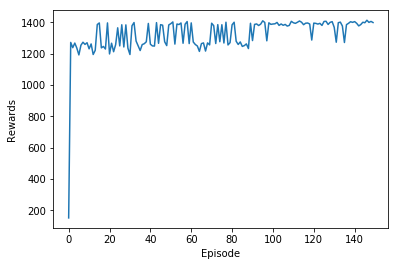

In [22]:
# The first 10 scores correspond to a failed run, so they are omitted from this plot

plt.plot(scores[10:])  
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.show()

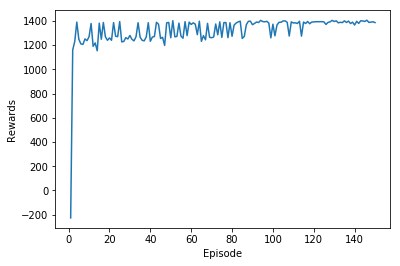

In [46]:
# Here I plot the episode rewards from a previous saved run. The performance is similar.

trained = pd.read_csv('trained_copter.csv') 
plt.plot(trained.groupby('Episode').sum()['Reward'])
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.show()

## Check Performance of Trained Agent

In [16]:
# The trained agent will now perform the takeoff task, but without undergoing any training.

agent.watch_agent();

Episode 1/150, score = 1403.5, Noise = 0.221, Time = 4.76, Final State: (-0.60, -0.45, 130.13)
Episode 2/150, score = 1407.4, Noise = 0.221, Time = 4.76, Final State: (-0.61, -0.23, 130.14)
Episode 3/150, score = 1377.8, Noise = 0.221, Time = 4.76, Final State: (3.34, -1.42, 130.11)
Episode 4/150, score = 1400.7, Noise = 0.221, Time = 4.76, Final State: (-1.01, 1.68, 130.12)
Episode 5/150, score = 1394.2, Noise = 0.221, Time = 4.76, Final State: (0.50, 2.82, 130.10)
Episode 6/150, score = 1402.8, Noise = 0.221, Time = 4.76, Final State: (-0.35, -0.34, 130.14)
Episode 7/150, score = 1391.9, Noise = 0.221, Time = 4.76, Final State: (-2.64, -0.85, 130.10)
Episode 8/150, score = 1406.2, Noise = 0.221, Time = 4.76, Final State: (-1.37, 0.31, 130.13)
Episode 9/150, score = 1388.9, Noise = 0.221, Time = 4.76, Final State: (0.66, -2.23, 130.12)
Episode 10/150, score = 1394.0, Noise = 0.221, Time = 4.76, Final State: (-3.13, -0.26, 130.09)
Episode 11/150, score = 1381.3, Noise = 0.221, Time = 4

Episode 88/150, score = 1384.5, Noise = 0.221, Time = 4.76, Final State: (-1.25, -3.63, 130.07)
Episode 89/150, score = 1397.0, Noise = 0.221, Time = 4.76, Final State: (1.41, 0.47, 130.16)
Episode 90/150, score = 1386.9, Noise = 0.221, Time = 4.76, Final State: (1.69, 2.73, 130.09)
Episode 91/150, score = 1400.7, Noise = 0.221, Time = 4.76, Final State: (-2.68, 0.25, 130.10)
Episode 92/150, score = 1368.1, Noise = 0.221, Time = 4.76, Final State: (3.18, 4.82, 130.05)
Episode 93/150, score = 1403.0, Noise = 0.221, Time = 4.76, Final State: (0.73, 0.47, 130.14)
Episode 94/150, score = 1380.6, Noise = 0.221, Time = 4.76, Final State: (4.00, -0.21, 130.09)
Episode 95/150, score = 1397.6, Noise = 0.221, Time = 4.76, Final State: (1.23, 0.55, 130.17)
Episode 96/150, score = 1388.8, Noise = 0.221, Time = 4.76, Final State: (-2.04, -1.91, 130.13)
Episode 97/150, score = 1396.3, Noise = 0.221, Time = 4.76, Final State: (-0.96, -1.55, 130.13)
Episode 98/150, score = 1393.4, Noise = 0.221, Time 

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:

The task I chose was a simple takeoff and pass a threshold $z$ position, which above I selected to be $z$ = 130. The reward function consists of three main components: a distance penalty, an angular penalty, and a velocity penalty. 

The distance penalty is:

$\frac{d(\textbf{u}_{xy}, \textbf{target}_{xy})}{d(\textbf{u}_{xy, min}, \textbf{u}_{xy, max})} - 2\times\frac{d(\textbf{u}_{z}, \textbf{target}_{z})}{d(\textbf{u}_{z, min}, \textbf{u}_{z, max})}$, 

where $d$ is the Euclidean distance, $\textbf{u}_{xy}$ is the vector of the $x$ and $y$ components of the copter, $\textbf{target}_{xy}$ is the vector of the $x$ and $y$ components of the target position, and $\textbf{u}_{xy, min}$ and $\textbf{u}_{xy, max}$ are the vectors of the minimum and maximum values of the $x$ and $y$ components in the environment ([-150, 150] and [150, 150], respectively), and similar for the $z$ component. The factor of 2 in front of the second term is to impart a higher penalty for being further from the target in the $z$ dimension, and was included to more strongly encourage the agent to move upward. The denominator terms are to normalize each term to [0, 1].

The angular penalty is:

$\frac{\theta + \phi + \psi}{6\pi}$,

where $\theta$, $\phi$, and $\psi$ are the pitch, roll, and yaw, respectively, and the factor of $\frac{1}{6\pi}$ is to normalize the angular penalty to [0, 1].

The velocity penality is:

$2\textrm{v}_z - |\textrm{v}_x| - |\textrm{v}_y|$,

where $\textrm{v}_{i}$ is the ith component of the copter's velocity. Here the agent is penalized for moving down but rewarded for moving up, whereas it is penalized for moving in any direction in the $xy$ plane. Again, the factor of 2 in front of $\textrm{v}_z$ was included to emphasize the importance of moving in the $z$ direction.

The three reward components were summed and divided by 10 to keep the rewards from being too large. Finally, various additional bonuses or penalties were included for the following conditions:

- running out of time before reaching the goal: -100
- going out of bounds (crashing into the walls of the environment): - 100
- passing the $z = \textbf{target}_{z}$ plane = +100
- getting within 5 units (in both $x$ and $y$) of the target position in the $xy$ plane when passing the $z = \textbf{target}_{z}$ plane: +100

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:

- I used the provided DDPG agent class for this project. Up to this point, I had only experimented with discretization and DQN algorithms using OpenAI environments, so this seemed like a great opportunity to try out DDPG. As suggested in the project instructions, I first tested the DDPG agent with the MountainCarContinuous and Pendulum OpenAI Gym environments, and with modification to the neural network architecture it worked well, so I decided to go forward using that for the copter project. I modified the provided DDPG agent to be compatible with both OpenAI Gym environments and the copter project, and included additional functionality like prioritized replay, various OU Noise decay programs (linear, exponential, decay upon success), min_max scaling for the state vector, the ability to train every step, n steps, or episode, a record storing for states, actions, rewards, etc., and the ability to both train and watch trained agents directly using the DDPG class.
- Although I tried several values, I ended up using the default value for $\gamma$ of 0.99. Exploration was dictated by the OU Noise, and here I kept the default values of $\mu = 0$, $\theta$ = 0.15 and $\sigma$ = 0.2, though again, I played with the values in both this project as well as with MountainCarContinuous and Pendulum. I found that in all cases the default values were adequate. As mentioned above, I implemented different programs for decaying the noise, which I do implement here (using exponential decay) to slowly reduce exploration. The other things I played with were the memory buffer size and the batch size, and I found that 100000 and 128, respectively, worked well for the copter as well as for MountainCar and Pendulum. 
- I started off with the default architectures in the starter code (actor: 32/64/32 $\rightarrow$ sigmoid; critic: states 32/64, actions 32/64, concat[states,actions] $\rightarrow$ linear), but found that they did not work well for me. I ended up reading the original DDPG paper (https://arxiv.org/pdf/1509.02971.pdf) and decided to follow their lead of (actor: 400/300 $\rightarrow$ tanh; critic: states 400, concat[states,actions], 300 $\rightarrow$ linear), and this worked beautifully when I was testing out the MountainCar and Pendulum environments, so I went forward with the copter project using these architectures. One thing I changed was just to use a sigmoid with scaling as the output for the actor instead of tanh (as in the provided DDPG class), since the scaling factor is a bit more straightforward in the sigmoid case. I also added an addition 200 node layer to both the actor and critic because I found that the copter performed better with it. The kernel initializations I used were random normal with limits of [-1/sqrt(n), -1/sqrt(n)], where n is the number of nodes in the hidden layer, and [-3e-3, 3e-3] in the final layer, just as in the referenced paper. In the critic network, I concatenated the action imputs with the output of the first hidden layer, again as in the referenced paper. The activation functions used were ReLU in all hidden layers, sigmoid in the output layer of the actor, and linear (no activation) in the output layer of the critic. I tried using L2 regularization in both the actor and the critic, as well as just in the critic, but I found that this was not helpful so I removed it. The optimzer for both the actor and critic was Adam with the default parameters in Keras. In the case of MountainCar and Pendulum, the learning rate for the actor was 1e-4, and 1e-3 for the critic, and for the copter each was increased by a factor of 10 because I found that this caused the agent to be more frequently successful in learning the task. 
- Finally, I want to note that although I set up the prioritized replay buffer gathering inspiration from (https://medium.com/ml-everything/reinforcement-learning-with-sparse-rewards-8f15b71d18bf), it did not work well for me and only made training the agent less successful. My initial feeling is that since I did not design the reward function to provide sparse rewards, prioritizing the replay buffer is perhaps not applicable. Also, both Pendulum and MountainCarContinuous do not have sparse rewards either (although MountainCar has a large bonus at the end, there are non-zero rewards being provided at every step), perhaps I should not have expected it to work well. Anyway, it's there in case I ever need it. I found that when training after every step, sorting a list of 1e5 elements made training terribly slow, so I implemented an option in which a subset of the memory buffer, say a factor of 10 or 100 smaller, could first be randomly selected, and the prioritized samples are prepared based on the subset.

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:

- With the neural networks described above, this was more or less an easy task for the agent to learn. You can see above that the agent learned the basic task of just crossing the z threshold after a single episode. After about 100 episodes or so (sometimes it takes longer), the agent more frequently is able to obtain the extra bonus of getting within $\pm 5$ of the target position in the $xy$ plane. In the section above 'Check Performance of Trained Agent', the agent is able to obtain this extra bonus every time. When I implemented the default networks provided in the starter code, I wasn't really getting the agent to learn, so I quickly moved to the architecture described above. One thing I will note, which is mentioned in a code comment above, is I found that with the implemented architectures, the agent would usually very quickly learn the task (within 5 episodes) and never forget it, but would occasionally appear to immediately get stuck in some kind of local optimum perhaps, and either not come out or take a very long time to come out. Considering this, it seemed more efficient to evaluate early whether this had happened, and just reset the training procedure if it had. I coded this up as an option in the train_agent method of the DDPG agent class. In the case of Pendulum, there seemed to be much more gradual improvement in the policy, but with MountainCar I saw something a bit different where the agent would oscillate between failing to reach the goal and succeeding for about 50 episodes, but would then suddenly 'latch on' and learn to reach the goal for good. Here, given how quickly the agent was able to learn the policy, it seemed more efficient to just reset the training if it looked like the agent was struggling.
- As described above, it was really an aha moment, which happened very quickly, usually within 5 episodes. 
- Once the agent learned the task, the performance was quite good. It did not suddenly fail so the rewards were consistent, and as shown below was usually not wildly off target and with good orientation (Euler angles close to 0).

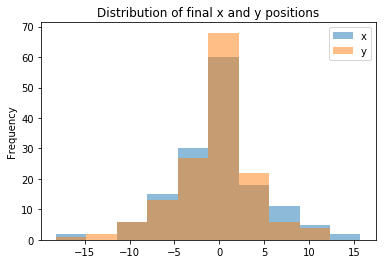

In [36]:
# Plot of the final x and y positions of the copter after successful episodes

df = pd.DataFrame(agent.record)
success = df[df['Episode'] != 1]  # I omit the first episode because the agent did not make it to the target position.
success[success['Done'] == True][['x', 'y']].plot(kind='hist', 
                                                  alpha=0.5, 
                                                  title='Distribution of final x and y positions');

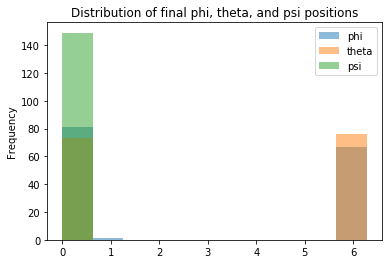

In [35]:
# Plot of the final phi, theta, and psi positions of the copter after successful episodes

success[success['Done'] == True][['phi', 'theta', 'psi']].plot(kind='hist', 
                                                               alpha=0.5, 
                                                               title='Distribution of final phi, theta, and psi positions');

In [47]:
# Interestingly, sometimes the angles end up at 2pi, but if you look at the DataFrame below (see phi column) 
# it doesn't seem like the copter actually sweeps through 0 --> 2pi. The change happens suddenly in a single 
# time step. I think what actually happens is that the angle goes extremely slightly negative and the code 
# angle = (angle + 2 * np.pi) % (2 * np.pi) in the next_timestep method of the PhysicsSim class returns that as 2pi.

success[success['Episode'] == 2].head()

,x,y,z,phi,theta,psi,Action 0,Action 1,Action 2,Action 3,...,Lin_v y,Lin_v z,Ang_v 0,Ang_v 1,Ang_v 2,Reward,Done,Noise scale,Episode,Step
251,0.000000e+00,0.000000e+00,10.000000,0.000000e+00,0.000000e+00,0.0,900.000000,900.0,899.972900,899.878784,...,0.000000e+00,0.777749,-0.000775,0.000000,0.0,0.175555,False,0.9900,2,1
252,0.000000e+00,0.000000e+00,10.007777,3.004636e-07,0.000000e+00,0.0,899.850281,900.0,900.000000,900.000000,...,2.924436e-07,1.554857,-0.000775,0.001233,0.0,0.297659,False,0.9801,2,2
253,0.000000e+00,2.924436e-09,10.031104,6.283170e+00,7.603188e-07,0.0,900.000000,900.0,900.000000,899.963013,...,-1.447843e-05,2.330205,-0.001080,0.001233,0.0,0.452753,False,0.9801,2,3
254,-7.386862e-09,-1.389354e-07,10.069954,6.283155e+00,2.542315e-05,0.0,900.000000,900.0,900.000000,900.000000,...,-4.417863e-05,3.102580,-0.001080,0.001234,0.0,0.607259,False,0.9801,2,4
255,-2.684028e-07,-7.255059e-07,10.124282,6.283133e+00,5.009058e-05,0.0,900.000000,900.0,899.991638,900.000000,...,-9.458560e-05,3.870800,-0.001012,0.001234,0.0,0.760939,False,0.9801,2,5


**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:

- The most difficult aspect was the preliminary work involved. As mentioned, based on the suggestion I tried to solve the OpenAI Gym MountainCarContinuous-v0 and Pendulum-v0 environments first, and it took me well over a week to achieve this. Using the provided DDPG agent with the default actor and critic just did not work for me, and without any prior experience in this area, I had no idea know why. This led me to implement the priority replay, the state vector scaling, etc., all the extra 'features' in the DDPG class that I really didn't end up using or needing in the end. In the end, it was really changing the neural network architectures according to the Lillicrap et al paper that helped me. But it was a great experience to go through that and look into the literature and find what worked for others in the past. And one result is that now I have what I feel is a more thorough DDPG agent class that I can use in the future. Plotting was not really an issue because I feel that I set up the record storage fairly decently in the DDPG class so that it can be fed into Pandas easily. The one thing that I did not do that I would like to in the future is to get a class method set up for quickly plotting the value and policy functions. This seemed difficult here because the state and action vectors are many dimensional, but it would be cool to have for lower dimensional problems.
- One interesting thing I noticed was that my agent did not work well with action repeats set to 3, so I set it to either 1 or 2 (for this submission 1 is used), both of which worked fine. I am not sure why it didn't work as well with 3. Apart from that, the most interesting thing was what I mentioned above in terms of the way the agent learned--either learning the task almost immediately and never forgetting, or not learning the task immediately and sometimes never coming out of whatever hole it got stuck in. Maybe if I had waited longer, it would have found it's way out of whatever local optimum it was stuck in, but again, given that it was so clear whether the agent had succeeded in learning within just a few episodes, it seemed much more efficient to just discard the bad runs programatically.  